#### About
Customer Segmentation using Lightgbm, XGBoost and Cat-Boost.

Dataset - https://www.kaggle.com/datasets/carrie1/ecommerce-data

#### About

* K-means clustering is a method of vector quantization that aims to partition n observation into K clusters in which each observation belongs to the cluster with nearest mean(cluster center/centroid).

>>> The primary difference between Catboost, Xgboost and Lightgbm are as follows - 

>> Boosting algorithms work on the principle of combining multiple models togethers i.e Residual of one model shall go into the other model as target.

> A. Decision Tree Structre over iterations - In catboost - Decision trees are symmetric. In LightGBM, They are growing Leafwise whereas Xgboost encounters depthwise decision trees.

> B. Handling of Categorical variables - In cat boost, Ordered Encoding is done whereas in LightGBM, The approach is Bin or Bucket based. In Extreme gradient boost, You have no predefined approach and hence one has to manually encode to one hot encoded.

> C.Selection of Samples - In Catboost, Minimimum variance and uniform variance sampling whereas for Gradient one side samplling is observed in LightGBM but in Bootstrap based sampling in Xtreme gradient boosting.

In [53]:
#neccessary imports
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [32]:
dataset = '/home/suraj/ClickUp/Jan-Feb/data/data.csv'
df = pd.read_csv(dataset)

In [33]:
print("Number of entries in the dataframe is {}".format(len(df)))

Number of entries in the dataframe is 541909


In [34]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### 1. Preprocessing data


In [35]:
#converting inovice date to date time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [36]:
#checking null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [37]:
#dropping null values
df.dropna(axis=0, inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [38]:
print("Number of entries in the dataframe after dropping null values is {}".format(len(df)))

Number of entries in the dataframe after dropping null values is 406829


In [39]:
df['TotalPurchase'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [40]:
#dropping duplicates
df.drop_duplicates(inplace=True)
print("Number of entries in the dataframe after dropping duplicate values is {}".format(len(df)))

Number of entries in the dataframe after dropping duplicate values is 401604


In [42]:
# viewing the number of customers, products and transaction made
print("Number of products are {}".format(len(df['StockCode'].value_counts())))
print("Number of unique transactions including cancel transactions are {}".format(len(df['InvoiceNo'].value_counts())))
print("Number of customers are {}".format(len(df['CustomerID'].value_counts())))

Number of products are 3684
Number of unique transactions including cancel transactions are 22190
Number of customers are 4372


#### Task Overview
We have to segment 4372 customers who bought 3684 products over 22k transactions.

In [51]:
#checking which country has maximum transactions
df.Country.value_counts()

United Kingdom          356728
Germany                   9480
France                    8475
EIRE                      7475
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1471
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [52]:
#checking the volume of cancelled orders
df['cancelled_orders'] = df['InvoiceNo'].apply(lambda x:int('C' in x))
a = df['cancelled_orders'].sum()
b = df.shape[0]
print("Number of cancelled orders are {}".format(a/b*100))

Number of cancelled orders are 2.209141343213713


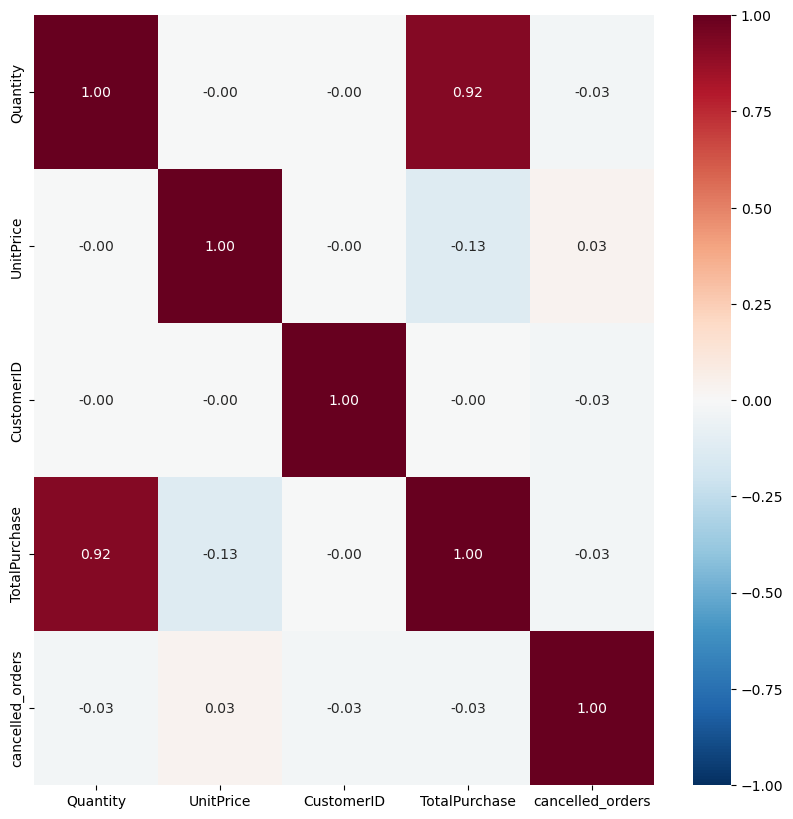

In [54]:
#checking the correlation of attributes in the dataframe
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='RdBu_r', annot=True,vmax=1, vmin=-1, fmt='.2f')
plt.show()

In [57]:
#keeping only customers who purchased and discarding all those who cancelled orders
df = df[df['Quantity']>0]


In [58]:
#observing the amount of customers who did repeated purchase
multiple_purchase = pd.DataFrame(df.groupby(['CustomerID'])[['InvoiceNo']].nunique())
multiple_purchase['InvoiceNo'] = multiple_purchase['InvoiceNo'].astype(int)
#sorting by greater than 1
multiple_purchase = multiple_purchase[multiple_purchase['InvoiceNo']>1]
print("Number of customers who did repeated purchase are {}".format(len(multiple_purchase)))

Number of customers who did repeated purchase are 2845


In [21]:
#let's create a new feature named days since purchase
df1['days_since_purchase'] = (today - df1["InvoiceDate"]).dt.days

In [37]:
#grouping all customer since days of purchase
df1_dop = df1.groupby("CustomerID").agg({"days_since_purchase":"min"})
df1_dop.reset_index(inplace=True)
df1_dop.columns = ["CustomerID","days_since_purchase"]
df1_dop.head()

#let's put this feature at hold for now !

,CustomerID,days_since_purchase
0,12346.0,4408
1,12347.0,4085
2,12348.0,4158
3,12349.0,4101
4,12350.0,4393


In [29]:
#creating a frequencey of purchase for a particular customer id grouped by Invoice number
df1_freq = df1.groupby("CustomerID").agg({"InvoiceNo":"nunique"})
df1_freq.reset_index(inplace=True)
df1_freq.columns = ["CustomerID","Frequency"]
df1_freq.head()


,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [30]:
# segregating total purchase made by a customer ID
df1_purchase = df1.groupby("CustomerID").agg({"TotalPurchase":"sum"})
df1_purchase.reset_index(inplace=True)
df1_purchase.columns = ["CustomerID","BillingAmount"]
df1_purchase.head()

,CustomerID,BillingAmount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [28]:
# merging all these 
df1_new = df1_freq.merge(df1_purchase, on="CustomerID")
df1_new

,CustomerID,Frequency,BillingAmount
0,12346.0,1,77183.60
1,12347.0,7,4310.00
2,12348.0,4,1797.24
3,12349.0,1,1757.55
4,12350.0,1,334.40
...,...,...,...
4333,18280.0,1,180.60
4334,18281.0,1,80.82
4335,18282.0,2,178.05
4336,18283.0,16,2094.88


In [33]:
df1_new.describe()

,CustomerID,Frequency,BillingAmount
count,4338.000000,4338.000000,4338.000000
mean,15300.408022,4.272015,2054.266460
std,1721.808492,7.697998,8989.230441
min,12346.000000,1.000000,3.750000
25%,13813.250000,1.000000,307.415000
50%,15299.500000,2.000000,674.485000
75%,16778.750000,5.000000,1661.740000
max,18287.000000,209.000000,280206.020000


In [34]:
# Total number of unique orders 
df1_new['CustomerID'].nunique()
# we have 4338 unique customer data.

4338

In [36]:
#unique product stock codes
df1_new['Frequency'].nunique()

59

In [38]:
#total number of purchases
#assuming each invoice represents a unique purchase
df1_new['BillingAmount'].nunique()

4284

In [39]:
#number of total purchase entres
len(df1_new)

4338